In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
'''
NOTE: This was done in Google Colab

The data (Minimum Daily Temperatures Dataset) is from 
Jason Brownlee's "7 Time Series Datasets for Machine Learning" article:
https://machinelearningmastery.com/time-series-datasets-for-machine-learning/

His datasets are found at:
https://github.com/jbrownlee/Datasets

This specific data is found at:
https://github.com/jbrownlee/Datasets/blob/master/daily-min-temperatures.csv

It is also found at:
https://www.kaggle.com/paulbrabban/daily-minimum-temperatures-in-melbourne/
'''
#Obtain Data:
df = pd.read_csv('/content/daily-min-temperatures.csv')
train, test = train_test_split(df,test_size=0.25)
train_x, train_y = train[['Date']], train[['Temp']]
test_x,train_y = test[['Date']], test[['Temp']]


Epoch 1/80
69/69 [==============================] - 0s 3ms/step - loss: 0.1688 - mae: 0.3320 - mse: 0.1688 - val_loss: 0.0462 - val_mae: 0.1729 - val_mse: 0.0462
Epoch 2/80
69/69 [==============================] - 0s 2ms/step - loss: 0.0971 - mae: 0.2498 - mse: 0.0971 - val_loss: 0.0283 - val_mae: 0.1337 - val_mse: 0.0283
Epoch 3/80
69/69 [==============================] - 0s 2ms/step - loss: 0.0665 - mae: 0.2031 - mse: 0.0665 - val_loss: 0.0263 - val_mae: 0.1289 - val_mse: 0.0263
Epoch 4/80
69/69 [==============================] - 0s 2ms/step - loss: 0.0553 - mae: 0.1844 - mse: 0.0553 - val_loss: 0.0227 - val_mae: 0.1193 - val_mse: 0.0227
Epoch 5/80
69/69 [==============================] - 0s 2ms/step - loss: 0.0499 - mae: 0.1756 - mse: 0.0499 - val_loss: 0.0213 - val_mae: 0.1156 - val_mse: 0.0213
Epoch 6/80
69/69 [==============================] - 0s 2ms/step - loss: 0.0396 - mae: 0.1557 - mse: 0.0396 - val_loss: 0.0213 - val_mae: 0.1156 - val_mse: 0.0213
Epoch 7/80
69/69 [==========

,Datetime,PredictedTemp1,TrueValue
0,1981-01-01,0.486391,0.787072
1,1981-01-02,0.480302,0.680608
2,1981-01-03,0.477506,0.714829
3,1981-01-04,0.481321,0.555133
4,1981-01-05,0.472470,0.600760
...,...,...,...
3645,1990-12-27,0.431512,0.532319
3646,1990-12-28,0.439341,0.517110
3647,1990-12-29,0.456419,0.513308
3648,1990-12-30,0.449993,0.596958


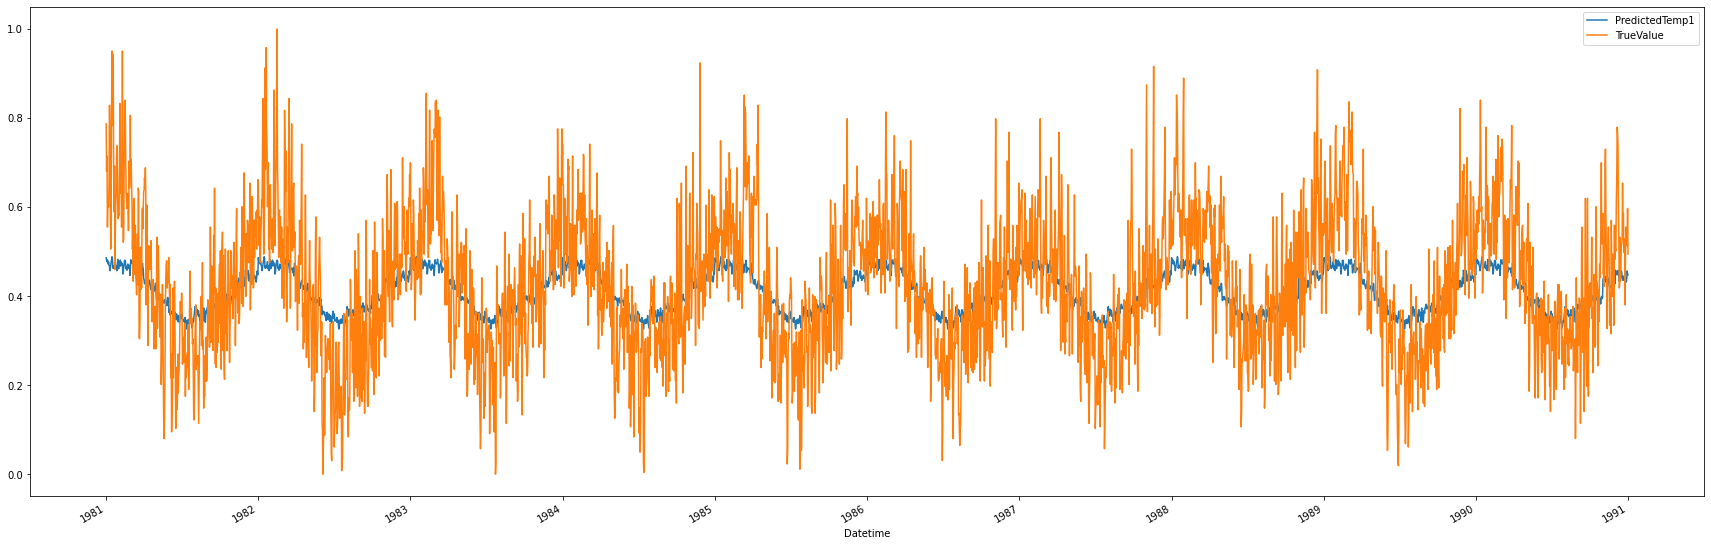

In [24]:
'''
Naive approach
-Convert Date into Year,Month,Days. These should become one-hot variables.
-Suppose the idea of years is not in this model.
-The idea is that the model notices that winter months should be colder than summer months.
'''
import tensorflow as tf
import tensorflow.keras
from datetime import datetime
from tensorflow.keras import layers, Sequential
from sklearn.preprocessing import MinMaxScaler 




def build_model():
  model = Sequential([
      layers.Flatten(input_shape=(43,)),
      layers.Dropout(0.5),
      layers.Dense(43,activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(1),
    ])
  
  model.compile(optimizer='adam',loss='mse',metrics=['mae','mse'])

  return model

def convertDates(df):
  dateConverted = df[['Date']].apply([
      lambda d : datetime.strptime(d.Date, '%Y-%m-%d'),
      lambda d : d.Date[:4],
      lambda d : d.Date[5:7],
      lambda d : d.Date[8:]
      ],axis=1).set_axis(['Datetime','Year','Month','Day'],axis=1)

  #One Hot conversion for dates
  for c in ['Month','Day']:
      oneHot = pd.get_dummies(dateConverted[c],prefix=c)
      dateConverted = dateConverted.drop(c,axis=1)
      dateConverted = dateConverted.join(oneHot)
  return dateConverted

def normalizeTemp(df):
  mms = MinMaxScaler()
  normalized_train_y = mms.fit_transform(df[['Temp']])
  return normalized_train_y

def massageData(df):
  #Expand Dates
  dateConverted = convertDates(df)
  #Remove certain columns
  dateConverted.pop('Datetime')
  dateConverted.pop('Year')

  #Normalize tempatures
  return dateConverted, normalizeTemp(df)

df = pd.read_csv('/content/daily-min-temperatures.csv')
new_dates, new_temp = massageData(df)


train_x, test_x, train_y, test_y = train_test_split(new_dates, new_temp,test_size=0.25)
model = build_model()
model.fit(train_x,train_y,epochs=80,validation_split=0.2)
model.evaluate(test_x,test_y,verbose=1)
'''
The naive approach seems to think more in terms of averages rather than actual predictions.
Also, the predictions, once outside the range of years, may become wildly inaccurate.
'''
df = pd.read_csv('/content/daily-min-temperatures.csv')

convertedDates = convertDates(df)
predicted1 = pd.DataFrame(model.predict(convertedDates[convertedDates.columns[2:]]),columns=['PredictedTemp1'])
temps = predicted1.join(pd.DataFrame(normalizeTemp(df[['Temp']]),columns=['TrueValue']))
datetimeToTemp = convertedDates[['Datetime']].join(temps)

datetimeToTemp.plot('Datetime',figsize=(30,10))
datetimeToTemp

29/29 [==============================] - 0s 1ms/step - loss: 0.0140 - mae: 0.0916 - mse: 0.0140


,Datetime,PredictedTemp1,PredictedTemp2,TrueTemp
0,1981-01-31,0.461597,0.515344,0.585551
1,1981-02-01,0.476481,0.511851,0.581749
2,1981-02-02,0.469314,0.507244,0.714829
3,1981-02-03,0.470309,0.508666,0.832700
4,1981-02-04,0.480833,0.532296,0.756654
...,...,...,...,...
3615,1990-12-27,0.431512,0.459693,0.532319
3616,1990-12-28,0.439341,0.438412,0.517110
3617,1990-12-29,0.456419,0.456225,0.513308
3618,1990-12-30,0.449993,0.457890,0.596958


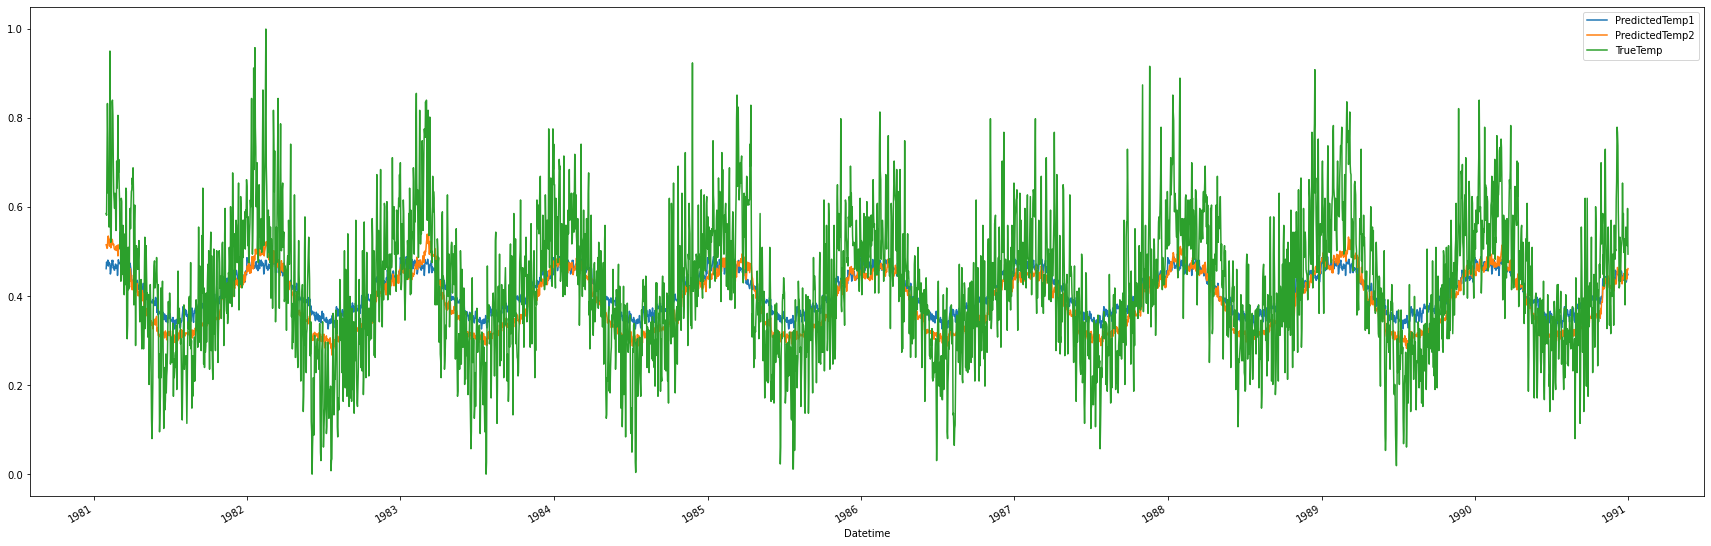

In [25]:
'''
Less Naive approach? (AKA, "featurize the past?")
-Convert Date into Year,Month,Days. These should become one-hot variables.
-Suppose the idea of years is not in this model.
-Add a feature column that contains the previous 30 days of temperatures.
-The idea is that previous days can affect the next.
'''
import numpy as np
import tensorflow as tf
import tensorflow.keras
from datetime import datetime
from tensorflow.keras import layers, Sequential
from sklearn.preprocessing import MinMaxScaler 




def build_model():
  model = Sequential([
      layers.Flatten(input_shape=(73,)),
      layers.Dropout(0.5),
      layers.Dense(73,activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(1),
    ])
  
  model.compile(optimizer='adam',loss='mse',metrics=['mae','mse'])

  return model

def convertDates(df):
  dateConverted = df[['Date']].apply([
      lambda d : datetime.strptime(d.Date, '%Y-%m-%d'),
      lambda d : d.Date[:4],
      lambda d : d.Date[5:7],
      lambda d : d.Date[8:]
      ],axis=1).set_axis(['Datetime','Year','Month','Day'],axis=1)

  #One Hot conversion for dates
  for c in ['Month','Day']:
      oneHot = pd.get_dummies(dateConverted[c],prefix=c)
      dateConverted = dateConverted.drop(c,axis=1)
      dateConverted = dateConverted.join(oneHot)
  return dateConverted

def normalizeTemp(df):
  mms = MinMaxScaler()
  normalized_train_y = mms.fit_transform(df[['Temp']])
  return normalized_train_y

def massageData(df):
  #Expand Dates
  dateConverted = convertDates(df)
  #Remove certain columns
  dateConverted.pop('Datetime')
  dateConverted.pop('Year')

  #Normalize tempatures
  return dateConverted, normalizeTemp(df)

df = pd.read_csv('/content/daily-min-temperatures.csv')
new_dates, new_temp = massageData(df)

new_temp_df = pd.DataFrame(new_temp,columns=['Temp'])


#Add the past into it.
for i in range(1,31):
  new_dates['temp_days_minus_'+str(i)] = new_temp_df[['Temp']].shift(i)

new_dates = new_dates[30:] 
new_temp = new_temp[30:] 

train_x, test_x, train_y, test_y = train_test_split(new_dates, new_temp,test_size=0.25)
model = build_model()
model.fit(train_x,train_y,epochs=80,validation_split=0.2,verbose=0)
model.evaluate(test_x,test_y,verbose=1)

'''
This still seems to have the same issues with the last one.
The only apparent difference is that the second model seems to
follow the extremes more closely.
'''
df = pd.read_csv('/content/daily-min-temperatures.csv')

convertedDates = convertDates(df)[30:]
predicted1edited = predicted1[30:]
predicted1edited.index = convertedDates.index = range(0,len(convertedDates))
predicted2 = pd.DataFrame(model.predict(new_dates),columns=['PredictedTemp2'])
temps = predicted1edited.join(predicted2).join(pd.DataFrame(new_temp,columns=['TrueTemp']))
datetimeToTemp = convertedDates[['Datetime']].join(temps)


datetimeToTemp.plot('Datetime',figsize=(30,10))
datetimeToTemp

(2714, 1)
(905, 1)
Epoch 1/80
68/68 [==============================] - 1s 16ms/step - loss: 0.1455 - mae: 0.1455 - mse: 0.0395 - val_loss: 0.0852 - val_mae: 0.0852 - val_mse: 0.0125
Epoch 2/80
68/68 [==============================] - 1s 11ms/step - loss: 0.0876 - mae: 0.0876 - mse: 0.0125 - val_loss: 0.0822 - val_mae: 0.0822 - val_mse: 0.0118
Epoch 3/80
68/68 [==============================] - 1s 12ms/step - loss: 0.0856 - mae: 0.0856 - mse: 0.0119 - val_loss: 0.0807 - val_mae: 0.0807 - val_mse: 0.0114
Epoch 4/80
68/68 [==============================] - 1s 12ms/step - loss: 0.0849 - mae: 0.0849 - mse: 0.0117 - val_loss: 0.0804 - val_mae: 0.0804 - val_mse: 0.0114
Epoch 5/80
68/68 [==============================] - 1s 11ms/step - loss: 0.0848 - mae: 0.0848 - mse: 0.0116 - val_loss: 0.0826 - val_mae: 0.0826 - val_mse: 0.0118
Epoch 6/80
68/68 [==============================] - 1s 11ms/step - loss: 0.0853 - mae: 0.0853 - mse: 0.0117 - val_loss: 0.0802 - val_mae: 0.0802 - val_mse: 0.0113
Epo

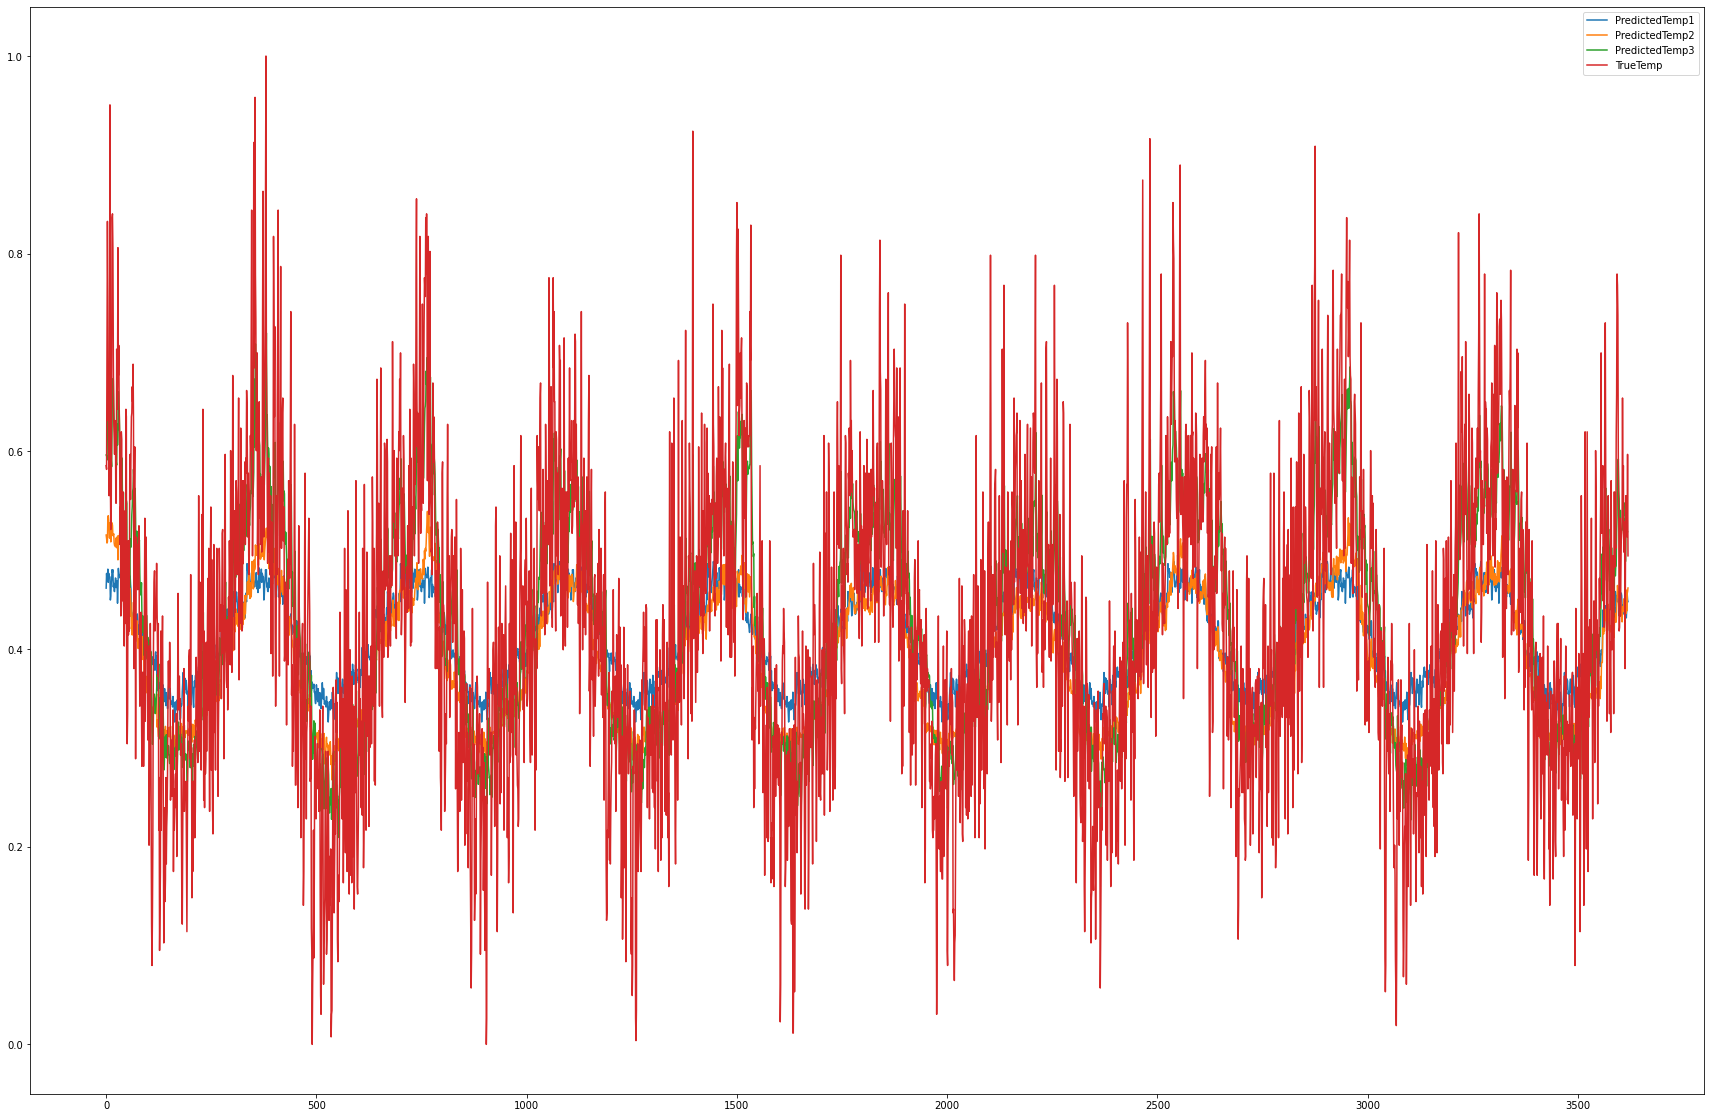

In [51]:
'''
Long-Short Term Memory approach.
-Use LSTM and concepts from RNN networks.
'''
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras
from sklearn.model_selection import train_test_split
from datetime import datetime
from tensorflow.keras import layers, Sequential
from sklearn.preprocessing import MinMaxScaler 





def convertDates(df):
  dateConverted = df[['Date']].apply([
      lambda d : datetime.strptime(d.Date, '%Y-%m-%d')
      ],axis=1).set_axis(['Datetime'],axis=1)
  return dateConverted

def normalizeTemp(df):
  mms = MinMaxScaler()
  normalized_train_y = mms.fit_transform(df[['Temp']])
  return normalized_train_y

def massageData(df):
  #Expand Dates
  dateConverted = convertDates(df)
  #Remove certain columns
  dateConverted.pop('Datetime')
  dateConverted.pop('Year')

  #Normalize tempatures
  return dateConverted, normalizeTemp(df)

df = pd.read_csv('/content/daily-min-temperatures.csv')
norm_temp =  normalizeTemp(df)




def build_model():
  model = Sequential([
      layers.LSTM(30,input_shape=(30,1)),
      layers.Dense(1),
    ])
  
  model.compile(optimizer='adam',loss='mae',metrics=['mae','mse'])

  return model

xs = np.array([
    np.reshape(norm_temp[i-31:i-1],(30,1))
    for i in range(31,len(norm_temp))])

ys = np.array([
    norm_temp[i]
    for i in range(31,len(norm_temp))])
c = ["temp_"+str(x) for x in range(1,31)]+["true_value"]

train_x, test_x, train_y, test_y = train_test_split(xs,ys,test_size=0.25)
model = build_model()

print(train_y.shape)
print(test_y.shape)

model.fit(train_x,train_y,validation_split=0.2,epochs=80)
model.evaluate(test_x,test_y,verbose=1)
'''
It appears RNNs really do work here.
'''
predicted3 = pd.DataFrame(model.predict(xs),columns=['PredictedTemp3'])
true = pd.DataFrame(ys,columns=['True'])
plot_me = datetimeToTemp.join(predicted3)
plot_me = plot_me[['PredictedTemp1','PredictedTemp2','PredictedTemp3','TrueTemp']]
plot_me.plot(figsize=(30,20))

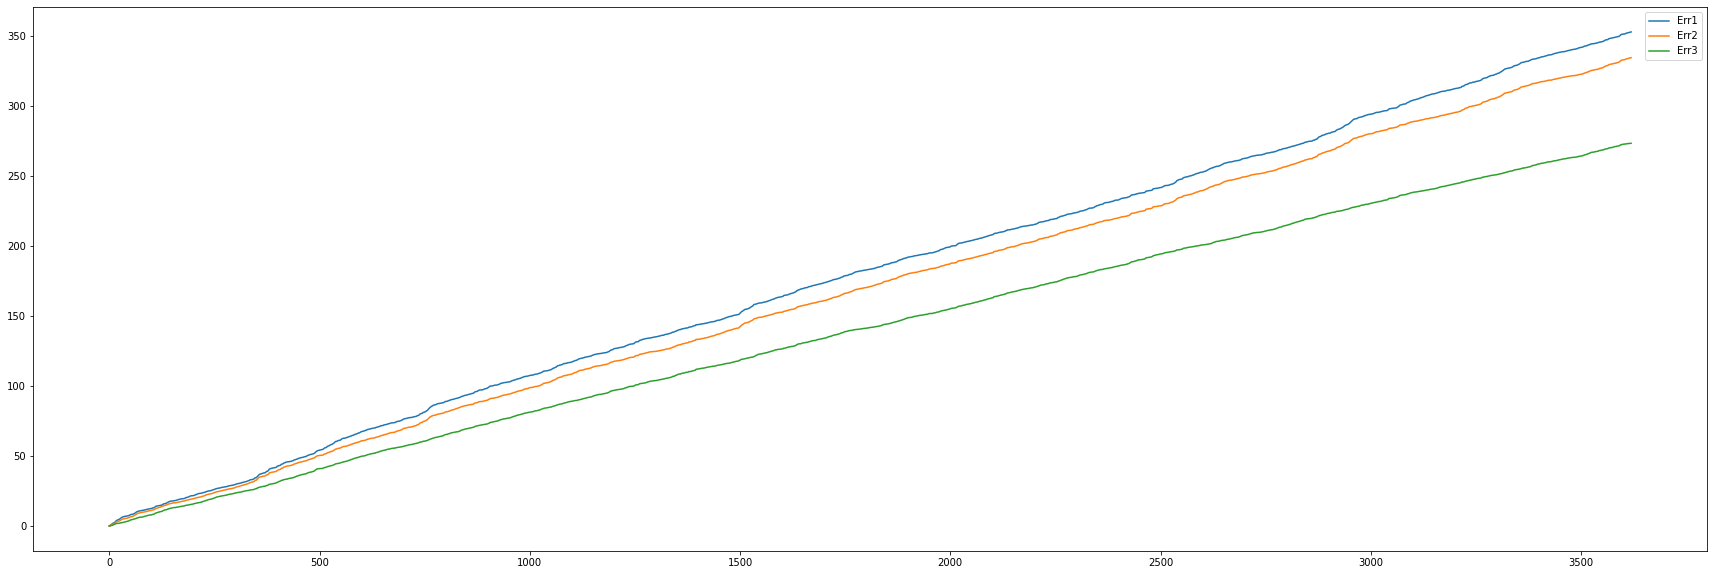

In [54]:
err = plot_me.apply([
  lambda a : abs(a.PredictedTemp1 - a.TrueTemp),
  lambda a : abs(a.PredictedTemp2 - a.TrueTemp),
  lambda a : abs(a.PredictedTemp3 - a.TrueTemp)
],axis=1).set_axis(['Err1','Err2','Err3'],axis=1)
#cumulative error comparison.
err.rolling(99999,min_periods=1).sum().plot(figsize=(30,10))